# OSMnx features demo

Author: [Geoff Boeing](https://geoffboeing.com/)

Get street networks and other spatial data anywhere in the world from OpenStreetMap then analyze and visualize them.

More info:

  - [Overview of OSMnx](http://geoffboeing.com/2016/11/osmnx-python-street-networks/)
  - [Documentation and install instructions](https://osmnx.readthedocs.io)
  - [Examples, demos, tutorials](https://github.com/gboeing/osmnx-examples)
  - [Journal article and citation info](http://geoffboeing.com/publications/osmnx-complex-street-networks/)
  - [GitHub repo](https://github.com/gboeing/osmnx)
  
This notebook provides a quick tour of some of OSMnx's key features including how to:

  - download/model street networks
  - calculate stats
  - visualize centrality
  - impute speeds/travel times and calculate shortest paths
  - attach and visualize elevation data and edge grades
  - download/model other infrastructure types
  - download points of interest data

In [2]:
import networkx as nx
import osmnx as ox

%matplotlib inline
ox.__version__

'1.5.0'

## Working with street networks

/Users/wray/miniforge3/envs/ox/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/wray/miniforge3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/wray/miniforge3/envs/ox/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


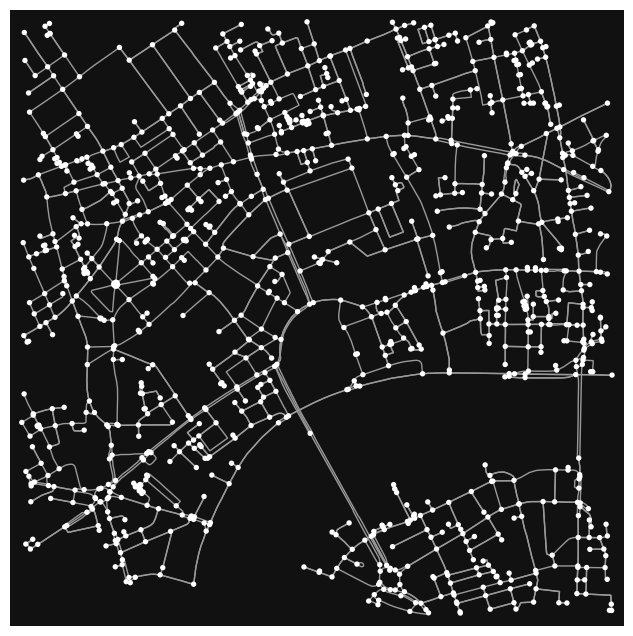

In [4]:
# download/model a street network for some city then visualize it
G = ox.graph_from_address("Bush House, Aldwych, London, UK", network_type="drive_service")
fig, ax = ox.plot_graph(G)

OSMnx geocodes the query "Piedmont, California, USA" to retrieve the place boundaries of that city from the Nominatim API, retrieves the drivable street network data within those boundaries from the Overpass API, constructs a graph model, then simplifies/corrects its topology such that nodes represent intersections and dead-ends and edges represent the street segments linking them. All of this is discussed in detail in the documentation and these examples.

OSMnx models all networks as NetworkX `MultiDiGraph` objects. You can convert to:
  - undirected MultiGraphs
  - DiGraphs without (possible) parallel edges
  - GeoPandas node/edge GeoDataFrames

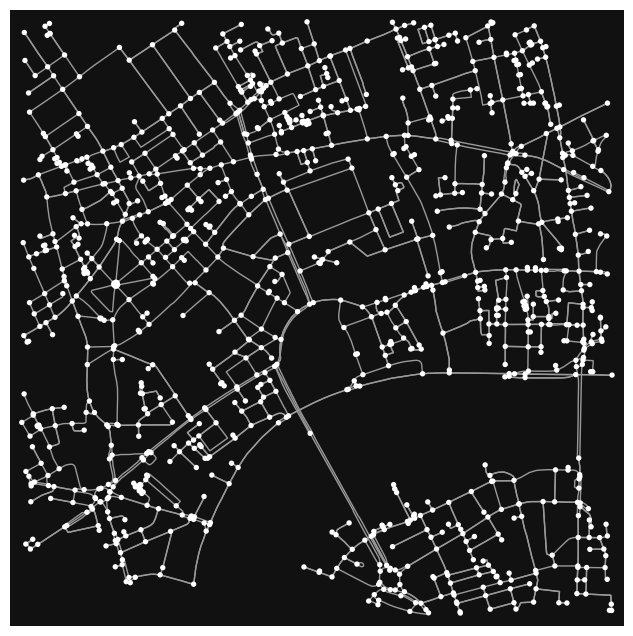

In [5]:
fig, ax = ox.plot_graph(
    G,
    ax=None,  # optionally draw on pre-existing axis
    figsize=(8, 8),  # figure size to create if ax is None
    bgcolor="#111111",  # background color of the plot
    node_color="w",  # color of the nodes
    node_size=15,  # size of the nodes: if 0, skip plotting them
    node_alpha=None,  # opacity of the nodes
    node_edgecolor="none",  # color of the nodes' markers' borders
    node_zorder=1,  # zorder to plot nodes: edges are always 1
    edge_color="#999999",  # color of the edges
    edge_linewidth=1,  # width of the edges: if 0, skip plotting them
    edge_alpha=None,  # opacity of the edges
    show=True,  # if True, call pyplot.show() to show the figure
    close=False,  # if True, call pyplot.close() to close the figure
    save=False,  # if True, save figure to disk at filepath
    filepath=None,  # if save is True, the path to the file
    dpi=300,  # if save is True, the resolution of saved file
    bbox=None,  # bounding box to constrain plot
)

## Routing

In [6]:
# impute missing edge speeds and calculate edge travel times with the speed module
G = ox.speed.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G)

In [13]:
# get the nearest network nodes to two lat/lng points with the distance module
orig = ox.distance.nearest_nodes(G, X=-122.245846, Y=37.828903)
dest = ox.distance.nearest_nodes(G, X=122.215006, Y=77.812303)

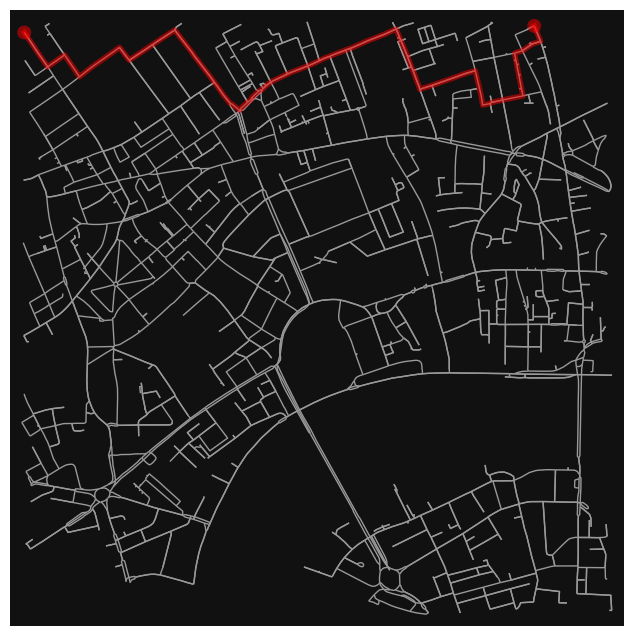

In [14]:
# find the shortest path between nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig, dest, weight="travel_time")
fig, ax = ox.plot_graph_route(G, route, node_size=0)

In [15]:
origin_point = (37.792896, -122.412325)
destination_point = (37.790495, -122.408353)
origin_node = ox.get_nearest_node(G, origin_point)
destination_node = ox.get_nearest_node(G, destination_point)
route = nx.shortest_path(G, origin_node, destination_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, origin_point=origin_point, destination_point=destination_point)

AttributeError: module 'osmnx' has no attribute 'get_nearest_node'

In [ ]:
# how long is our route in meters?
edge_lengths = ox.utils_graph.route_to_gdf(G, route)["length"]
round(sum(edge_lengths))

In [ ]:
# how far is it between these two nodes as the crow flies?
# use OSMnx's vectorized great-circle distance (haversine) function
orig_x = G.nodes[orig]["x"]
orig_y = G.nodes[orig]["y"]
dest_x = G.nodes[dest]["x"]
dest_y = G.nodes[dest]["y"]
round(ox.distance.great_circle_vec(orig_y, orig_x, dest_y, dest_x))

You can add elevation attributes to your graph's nodes automatically with the `elevation` module, using either local raster files or the Google Maps Elevation API.

In [ ]:
# add elevation to nodes automatically, calculate edge grades, plot network
# you need a google elevation api key to run this cell!
try:
    from keys import google_elevation_api_key

    G = ox.elevation.add_node_elevations_google(G, api_key=google_elevation_api_key)
    G = ox.elevation.add_edge_grades(G)
    nc = ox.plot.get_node_colors_by_attr(G, "elevation", cmap="plasma")
    fig, ax = ox.plot_graph(G, node_color=nc, node_size=20, edge_linewidth=2, edge_color="#333")
except ImportError:
    print("You need a google_elevation_api_key to run this cell.")

Nodes are colored from lowest elevation (dark blue) to highest (bright yellow).

Example: create [elevation-based](12-node-elevations-edge-grades.ipynb) impedance functions to route around hills.

## Get networks other ways

make queries less ambiguous to help the geocoder out, if it's not finding what you're looking for

In [ ]:
# you can make query an unambiguous dict to help the geocoder find it
place = {"city": "San Francisco", "state": "California", "country": "USA"}
G = ox.graph_from_place(place, network_type="drive", truncate_by_edge=True)
fig, ax = ox.plot_graph(G, figsize=(10, 10), node_size=0, edge_color="y", edge_linewidth=0.2)

In [ ]:
# you can get networks anywhere in the world
G = ox.graph_from_place("Sinalunga, Italy", network_type="all")
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.5)

In [ ]:
# or get network by address, coordinates, bounding box, or any custom polygon
# ...useful when OSM just doesn't already have a polygon for the place you want
wurster_hall = (37.870605, -122.254830)
one_mile = 1609  # meters
G = ox.graph_from_point(wurster_hall, dist=one_mile, network_type="drive")
fig, ax = ox.plot_graph(G, node_size=0)

Examples of [getting networks](01-overview-osmnx.ipynb) by coordinates, bounding box, or any custom polygon shape.

## Get other networked infrastructure types

...like rail or electric grids or even the canals of Venice and Amsterdam, using the `custom_filter` parameter: [see more examples](08-custom-filters-infrastructure.ipynb).

In [ ]:
# get NY subway rail network
G = ox.graph_from_place(
    "New York, New York, USA",
    retain_all=False,
    truncate_by_edge=True,
    simplify=True,
    custom_filter='["railway"~"subway"]',
)

fig, ax = ox.plot_graph(G, node_size=0, edge_color="w", edge_linewidth=0.2)

## Get any geospatial features' geometries and attributes

Use the `features` module to download any OSM features, such as local amenities, points of interest, or building footprints, and turn them into a GeoDataFrame: [see docs](https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.features). For more usage examples of downloading geospatial features from OSM, see [this notebook](16-download-osm-geospatial-features.ipynb).

In [ ]:
# get all building footprints in some neighborhood
place = "SoHo, New York, NY"
tags = {"building": True}
gdf = ox.features_from_place(place, tags)
gdf.shape

In [ ]:
fig, ax = ox.plot_footprints(gdf, figsize=(3, 3))

See the other notebooks for more examples of visualization with OSMnx.

In [ ]:
# get all parks and bus stops in some neighborhood
tags = {"leisure": "park", "highway": "bus_stop"}
gdf = ox.features_from_place(place, tags)
gdf.shape